<a href="https://colab.research.google.com/github/olesyamba/Risk_analysis/blob/main/Bonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Для хранения, обработки данных и математических вычислений
import numpy as np
!pip install --upgrade pandas>=1.2
import pandas as pd

# Для Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Для калибровки распределения и генерации случайных величин
import scipy.stats as ss
from scipy.interpolate import interp1d

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

#  Портфель облигации: ценообразование и меры чувствительности

- Бескупонная облигации:

  $B_t = N d(s) = N\cdot e^{-y_t(s)\cdot s}$, где  $N$ - номинал, $y_t(s)$ - процентна ставка непрерывного начисления (%/годовых), $s$ -срок до погашения в годах.

  - Чувствительность доходности облигации к изменению ставки $\frac{dB_t/B_t}{dr_t}$:
    - $\Delta  = -s = -D $, где $D$ - дюрация облигации.

- Купонную облигацию можно представить в виде совокупности бескупонных облигаций:

  $B_t = \sum_{i = 1}^N CF_{t_i}\cdot d(s_i) = \sum_{i = 1}^N CF_{t_i}\cdot e^{-y_t(s_i)\cdot s_i}$, где $CF_{t_i}$ - выплата в момент времени $t_i$.

  - Чувствительность к изменению параллельному сдвигу кривой  $\frac{dB_t/B_t}{dh}$ при $y_t(s) \mapsto y_t(s) + dh, \forall s$:

    - $\Delta = -D =  - \frac{\sum\limits_{i=1}^N s \cdot CF_{t_i} \cdot e^{-y_t(s_i) s_i}}{B_t}$


In [ ]:
# Функция ценообразования облигации

# Строим кривую доходности на заданную дату
def get_curve(rates:pd.DataFrame, curr_date: np.datetime64):
  rates_points = rates.loc[curr_date,:]
  return interp1d(rates_points.index,
                  rates_points.values/100,
                  kind = 'linear',
                  bounds_error = False,
                  fill_value=(rates_points.values[0],rates_points.values[-1]))


# Определяем потоки платежей по облигации
def get_bond_CF(bond_spec: dict, curr_date: np.datetime64):
  bond_CF ={
            'terms': (bond_spec['dates'][bond_spec['dates'] >= curr_date] - np.datetime64(curr_date)).astype('float')/365,
             'payments': bond_spec['payments'][bond_spec['dates'] >= curr_date],
             'curr_date': curr_date
  }
  return bond_CF

# Определяем стоимость облигации, как дисконтированный поток платежей
def bond_pricing(bond_CF, curr_curve):
  discount_factors = np.exp(- curr_curve (bond_CF['terms']) * bond_CF['terms'])
  price = discount_factors @ bond_CF['payments']
  duration = (bond_CF['payments']*discount_factors* bond_CF['terms']).sum()/price
  return {'price':price,'discount_factors':discount_factors, 'payments':bond_CF['payments'], 'duration': duration }


# Данные о кривых доходностях USA

In [ ]:
# Загрузим исторические данные о доходностях американских казначейских облигаций
# -> Спасибо инициативному чуваку за удобный хаб! Первичный источник - US FRS.

url = "https://raw.githubusercontent.com/epogrebnyak/data-ust/master/ust.csv"
data = pd.read_csv(url, parse_dates=["date"]).set_index("date")
rates = data.loc[data.index > '2010-01-01', data.columns[:-1]]
display(rates)

,BC_1MONTH,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR
date,,,,,,,,,,,
2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,0.17,0.38,0.75,1.07,1.55,1.68,1.71,1.77,1.78,2.29,2.19
2022-03-08,0.16,0.36,0.72,1.12,1.63,1.78,1.80,1.85,1.86,2.34,2.24
2022-03-09,0.18,0.38,0.75,1.15,1.68,1.83,1.87,1.92,1.94,2.38,2.29


In [ ]:
# Технический момент: создадим вектор срочностей ставок (в годах)

terms = pd.Series(np.array([ round(1/12,3), 3/12, 6/12, 1,   2,   3,   5,   7,   10,   20,   30]),
                                  ['1m',   '3m', '6m', '1y','2y','3y','5y','7y','10y','20y','30y'])
print(f'Вектор срочностей\n{terms}')

# Перенесем значения сроков к индексы столбцов  таблицы ставок
rates.columns = terms.values
display(rates)

Вектор срочностей
1m      0.083
3m      0.250
6m      0.500
1y      1.000
2y      2.000
3y      3.000
5y      5.000
7y      7.000
10y    10.000
20y    20.000
30y    30.000
dtype: float64


,0.083,0.250,0.500,1.000,2.000,3.000,5.000,7.000,10.000,20.000,30.000
date,,,,,,,,,,,
2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,0.17,0.38,0.75,1.07,1.55,1.68,1.71,1.77,1.78,2.29,2.19
2022-03-08,0.16,0.36,0.72,1.12,1.63,1.78,1.80,1.85,1.86,2.34,2.24
2022-03-09,0.18,0.38,0.75,1.15,1.68,1.83,1.87,1.92,1.94,2.38,2.29


In [ ]:
# Зададим спецификации облигации: размеры и даты потоков платежей
bond = {
     'dates':     np.array(['2020-04-13', '2020-10-13', '2021-04-13', '2021-10-13', '2022-04-13', '2022-10-13'], dtype='datetime64'),
     'payments': np.array([ 0.025,        0.025,       0.025,         0.025,        0.025,        1.025])
      }

# Зададим дату ценообразования обигации
curr_date = np.datetime64('2020-04-06')

# Посмотрим на кривую доходности для выбранной даты
curr_curve = get_curve(rates, curr_date)
print(f'Кривая доходности на {curr_date}:\n{pd.Series(curr_curve(terms), terms.index)}')

bond_CF = get_bond_CF(bond, curr_date)
print(f"\nПотоки платежей на {curr_date}:\n{pd.Series(bond_CF['payments'], bond_CF['terms'])}")

# Оценим стоимость облигации и ее чувствительность к параллельному сдвигу кривой доходности
bond_price = bond_pricing(get_bond_CF(bond, curr_date), curr_curve)

print(f"\nКоэффициенты дисконтирования на {curr_date}:\n{bond_price['discount_factors']}")
print(f"\nДисконтированные потоки на {curr_date}:\n{bond_price['discount_factors']*bond_price['payments']}")
print("\nCтоимость облигации на {:}: {:.4f}".format(curr_date, bond_price['price']))
print("\nЧувствительность (-1 * Дюрация) облигации на {:}: {:.4f}".format(curr_date, - bond_price['duration']))


Кривая доходности на 2020-04-06:
1m     0.0009
3m     0.0015
6m     0.0017
1y     0.0020
2y     0.0027
3y     0.0035
5y     0.0044
7y     0.0058
10y    0.0067
20y    0.0108
30y    0.0127
dtype: float64

Потоки платежей на 2020-04-06:
0.019178    0.025
0.520548    0.025
1.019178    0.025
1.520548    0.025
2.019178    0.025
2.520548    1.025
dtype: float64

Коэффициенты дисконтирования на 2020-04-06:
[0.99827546 0.99910905 0.99795007 0.9964113  0.99453224 0.99217564]

Дисконтированные потоки на 2020-04-06:
[0.02495689 0.02497773 0.02494875 0.02491028 0.02486331 1.01698003]

Cтоимость облигации на 2020-04-06: 1.1416

Чувствительность (-1 * Дюрация) облигации на 2020-04-06: -2.3566


# Анализ динамики кривых доходностей

Особенности:

 - зависимость - особая корреляционная структура
 - случайность ограничена сохранением формы (гладкости) кривой доходности  

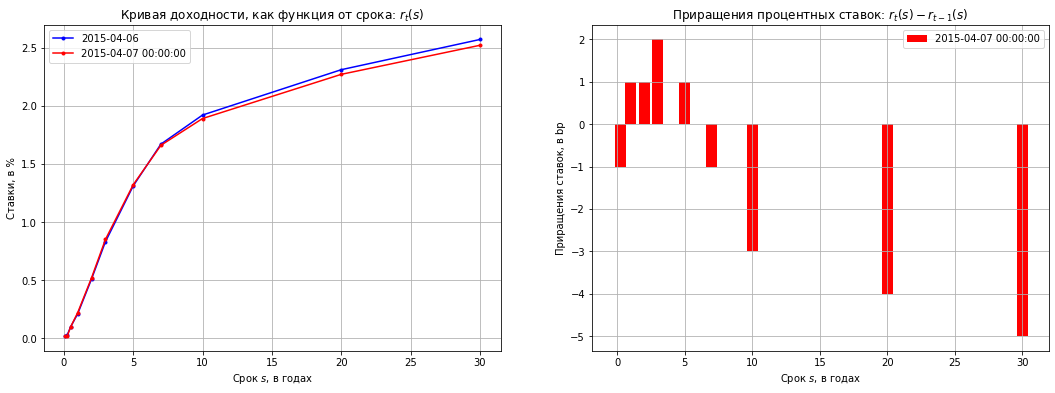

In [ ]:
# Изобразим кривую доходности и ее изменения во времени
date1 = np.datetime64('2015-04-06') #
date2 = rates.index[rates.index.get_loc(date1) + 1]

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

# Кривые доходности в последовательные даты
curve_plot = ax[0]
curve_plot.plot(terms, rates.loc[date1, :], 'b.-', label = date1)
curve_plot.plot(terms, rates.loc[date2, :], 'r.-', label = date2)
curve_plot.grid()
curve_plot.set_xlabel(r'Срок $s$, в годах')
curve_plot.set_ylabel('Ставки, в %')
curve_plot.set_title(r'Кривая доходности, как функция от срока: $r_t(s)$ ')
curve_plot.legend()

# График дневных приращений ставок разных сроков
diff_plot = ax[1]
diff_plot.bar(terms, 100*(rates.loc[date2, :] - rates.loc[date1, :]), color = 'red', label = date2)
diff_plot.set_xlabel(r'Срок $s$, в годах')
diff_plot.set_ylabel('Приращения ставок, в bp')
diff_plot.set_title(r'Приращения процентных ставок: $r_t(s) - r_{t-1}(s)$')
diff_plot.grid()
diff_plot.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  # Remove the CWD from sys.path while we load stuff.


,0.083,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0.083,1.00,0.37,0.28,0.20,0.10,0.08,0.05,0.04,0.05,0.05,0.05
0.25,0.37,1.00,0.62,0.43,0.26,0.22,0.17,0.15,0.15,0.13,0.13
0.5,0.28,0.62,1.00,0.62,0.42,0.37,0.31,0.27,0.26,0.23,0.22
1.0,0.20,0.43,0.62,1.00,0.66,0.61,0.51,0.46,0.42,0.36,0.34
2.0,0.10,0.26,0.42,0.66,1.00,0.90,0.82,0.75,0.69,0.59,0.56
3.0,0.08,0.22,0.37,0.61,0.90,1.00,0.93,0.87,0.81,0.71,0.66
5.0,0.05,0.17,0.31,0.51,0.82,0.93,1.00,0.97,0.92,0.83,0.79
7.0,0.04,0.15,0.27,0.46,0.75,0.87,0.97,1.00,0.97,0.91,0.87
10.0,0.05,0.15,0.26,0.42,0.69,0.81,0.92,0.97,1.00,0.96,0.93
20.0,0.05,0.13,0.23,0.36,0.59,0.71,0.83,0.91,0.96,1.00,0.98


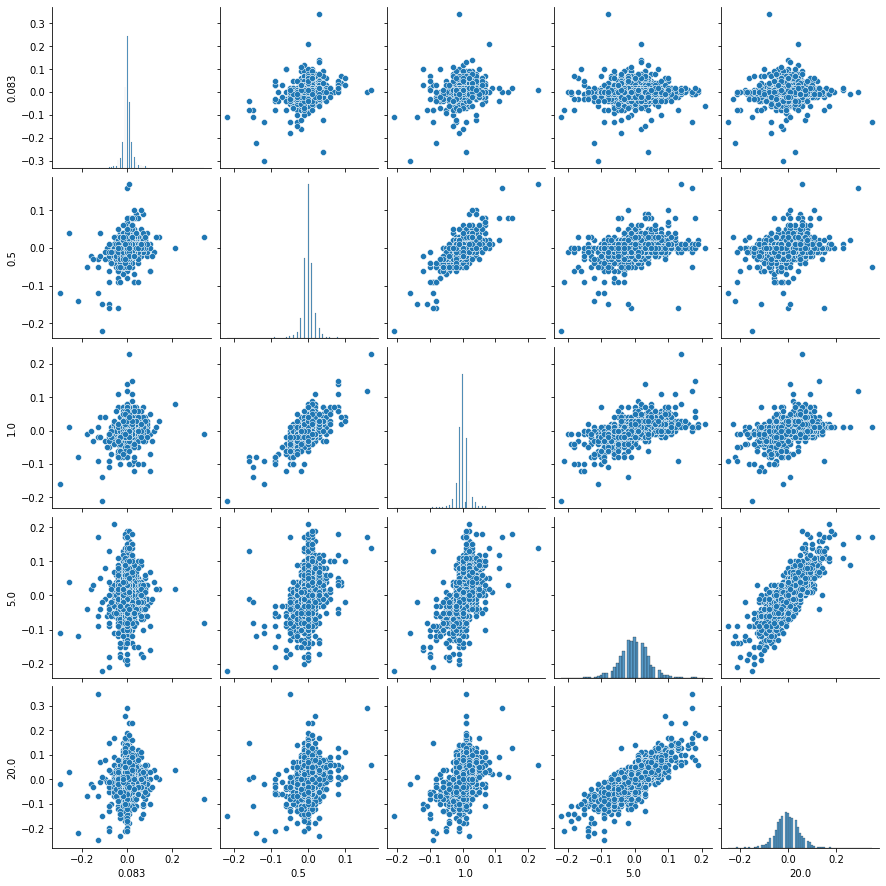

In [ ]:
# Изучим приращения
# Вычислим их
rates_diff = rates.diff().dropna()

# Составим графики для краткосрочных, среднесрочных и долгосрочных ставок
sns.pairplot(rates_diff.loc[:,[0.083, 0.5, 1, 5, 20]])

# Рассмотрим корреляционную матрицу
corr_m = rates_diff.corr()
corr_m.style.background_gradient(cmap='coolwarm').set_precision(2)

# Моделирование риск-факторов

Примечание: динамика стоимости облигаций имеет детерминированную часть, связанную с приближением времени погашения; VaR следует вычислять относительно сценария, что в будущем сохранится текущее положение кривой доходности.

- Простой исторический метод
  - исторические "деформации" кривой процентных ставок применяются к текущему положению кривой доходности

- Однофакторные модели:
  - апроксимация (параллельный сдвиг + дюрация)
    - предположение: все ставки сдвинутся на одину и ту же величину
      - нужно оценить наихудших сдвиг
      - дюрация отражает текущую чувствительность
  - модели короткой процентной ставки (за пределами курса)
    - кривые доходности однозначно определены короткой ставкой, сама по себе которая случайна.  


- Многофакторные модели:
 - ключевые ставки (обобщение идеи параллельного сдвига, только для отдельных ставок)
 - факторное разложение (PCA) - есть факторы, которые обладают разным масштабом и по-разному влияют на ставки разных срочностей.

# Простой исторический метод




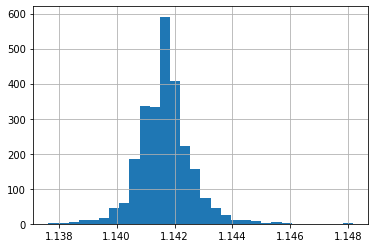


Current price: 1.1416,
Future reference price: 1.1417,
Future quantile price: 1.1393,
Relative VaR_99%: 0.21%
      


In [ ]:
# Текущая кривая доходность

bond = {
    'dates':     np.array(['2020-04-13', '2020-10-13', '2021-04-13', '2021-10-13', '2022-04-13', '2022-10-13'], dtype='datetime64'),
     'payments': np.array([ 0.025,        0.025,       0.025,         0.025,        0.025,        1.025])
      }


valuation_date = np.datetime64('2020-04-06')

# Текущая стоимость облигации
curr_price = bond_pricing(get_bond_CF(bond, valuation_date),
                          get_curve(rates.loc[:valuation_date, :], valuation_date))['price']

get_curve_vec = np.vectorize(get_curve, excluded = [0])
bond_pricing_vec = np.vectorize(bond_pricing, excluded=[0])

# Сценарии завтрашней кривой доходности
rates_diff = rates.loc[:valuation_date, :].diff().dropna() # исторические сценарии изменения процентных ставок
potential_rates = rates.loc[valuation_date, :].values + rates_diff # потенциальные кривые дохоходности завтра

# Сколько может стоить облигация завтра?
risk_date = np.datetime64('2020-04-07')
bond_CF = get_bond_CF(bond, risk_date)

# Базовой ценой
reference_price = bond_pricing(bond_CF, get_curve(rates.loc[:valuation_date, :], valuation_date))['price']
scenarios = bond_pricing_vec(
        bond_CF,
        get_curve_vec(potential_rates, potential_rates.index)
    )
potential_prices = pd.Series([x['price'] for x in scenarios])

plt.hist(potential_prices, bins = 30)
plt.grid()
plt.show()

level = .99
quantile_price = potential_prices.quantile(1 - level, interpolation = 'higher')
print(
    '''
Current price: {:.4f},
Future reference price: {:.4f},
Future quantile price: {:.4f},
Relative VaR_{:.0%}: {:.2%}
      '''.format(curr_price,
                 reference_price,
                 quantile_price,
                 level,
                 (reference_price - quantile_price)/reference_price
                 ))
#

#Однофакторная модель параллельного сдвига



Дюрация облигации 2.353808631820037
Relative VaR_99%: 0.35%
      


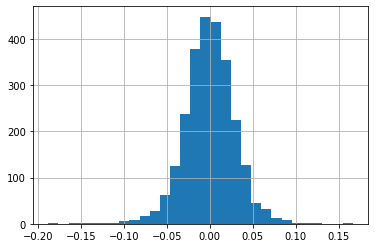

In [ ]:
# Наша облигация

bond = {
    'dates':     np.array(['2020-04-13', '2020-10-13', '2021-04-13', '2021-10-13', '2022-04-13', '2022-10-13'], dtype='datetime64'),
     'payments': np.array([ 0.025,        0.025,       0.025,         0.025,        0.025,        1.025])
      }

valuation_date = np.datetime64('2020-04-06')
risk_date = np.datetime64('2020-04-07')

duration = bond_pricing(get_bond_CF(bond, risk_date), get_curve(rates.loc[:valuation_date, :], valuation_date))['duration']
print('Дюрация облигации', duration)

# Используя параллельный сдвиг, мы получаем возможность строить модель распределения приращения
rates_diff = rates.loc[:valuation_date, :].diff().dropna()
rates_diff.mean(axis = 1).hist(bins = 30)
quant_diff = rates_diff.max(axis = 1).quantile(level, interpolation = 'lower') # хуже, когда процентные ставки растут
VaR = quant_diff*duration/100

print('''Relative VaR_{:.0%}: {:.2%}
      '''.format(
                 level,
                 VaR
                )
)

# PCA для процентных ставок

Идея -  найти ортоганальные друг другу факторы $f^j_t$, $j = \overline{1, k}$, такие что:

 $$r_t(s) = \beta_1(s) f^1_t +...+\beta_k(s)f^k_t$$


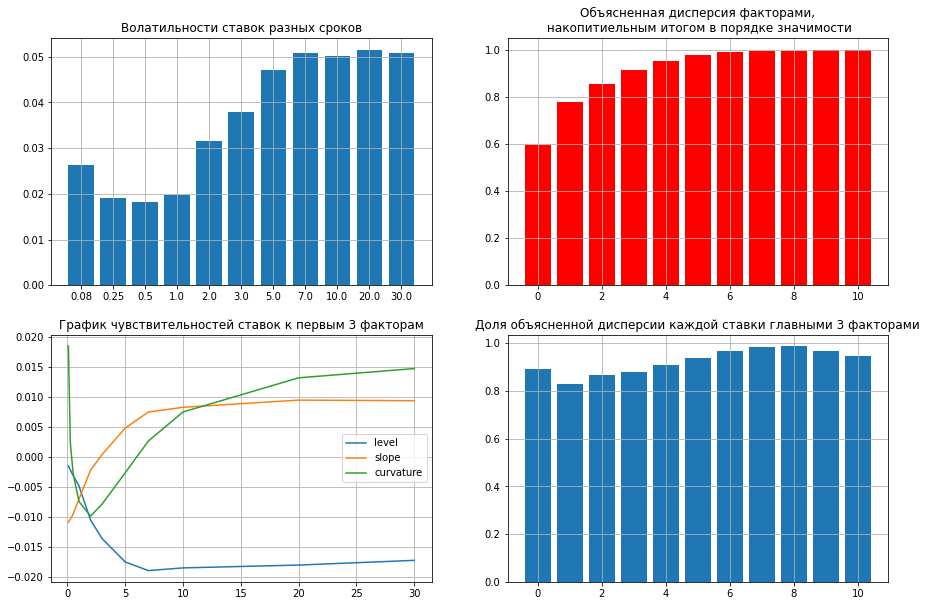

In [ ]:
valuation_date = np.datetime64('2020-04-06')
rates_diff = rates.loc[:valuation_date, :].diff().dropna()

diff_mean = rates_diff.values.mean(axis = 0) # Запоминаем среднее
diff_std = rates_diff.values.std(axis = 0) # Запоминаем волатильности ставок, они потребуются для обратной сборки модели

# Применим PCA для разложения ряда ставок на ортоганальные факторы
diff_scaled = StandardScaler().fit_transform(rates_diff.values) # Нормируем исходные данные
pca=PCA()
factors = pca.fit_transform(diff_scaled) # Получаем образы факторов нормированных данных

fig, axs = plt.subplots(2,2, figsize = (15,10))

diff_std_plot = axs[0,0]
diff_std_plot.bar([str(round(x,2)) for x in terms], diff_std)
diff_std_plot.set_title('Волатильности ставок разных сроков')
diff_std_plot.grid()

exp_var_plot = axs[0,1]
exp_var_plot.bar(range(terms.size), pca.explained_variance_ratio_.cumsum(), color = 'red')
exp_var_plot.set_title('Объясненная дисперсия факторами,\n накопитиельным итогом в порядке значимости')
exp_var_plot.grid()

# Зададим количество главных факторов
k = 3

coeff_plot = axs[1,0]
coeff_rescaled = pca.components_*np.expand_dims(diff_std, axis = 0)
coeff_plot.plot(terms, coeff_rescaled[:k,:].T)
coeff_plot.legend(['level','slope','curvature'])
coeff_plot.set_title(f'График чувствительностей ставок к первым {k} факторам')
coeff_plot.grid()

exp_rat_plot = axs[1,1]
exp_rat_plot.bar(range(terms.size), (factors[:,:k]@coeff_rescaled[:k,:]).std(axis = 0)/diff_std)
exp_rat_plot.set_title(f'Доля объясненной дисперсии каждой ставки главными {k} факторами')
exp_rat_plot.grid()

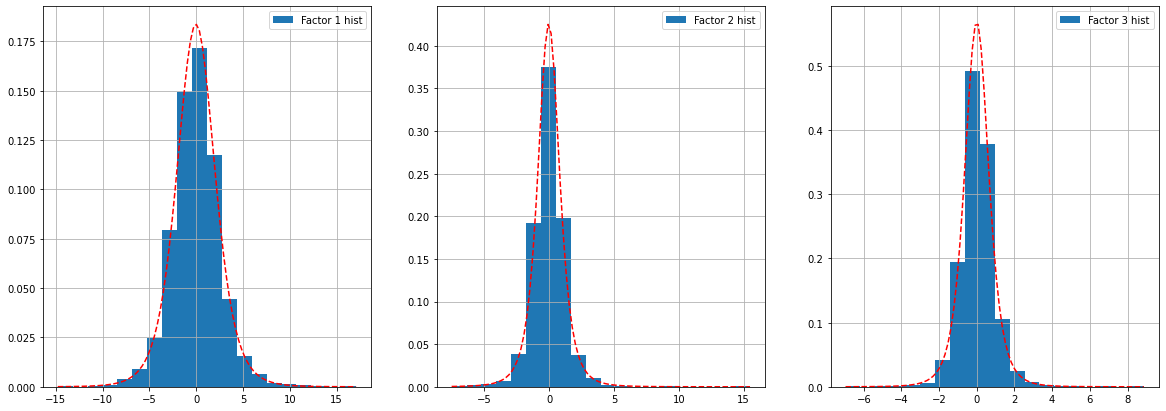

In [ ]:
# Замоделируем первые при компоненты

dist = ss.t

# factor1_m = dist.fit(factors[:,0])
# factor1_m

fig, axs = plt.subplots(1, 3, figsize = (20, 7))

models = []

for i in range(k):
  fct = factors[:,i]
  factor_mdl = dist.fit(fct)
  models.append(factor_mdl)
  x_val = np.linspace(fct.min(), fct.max(), 100)

  pic = axs[i]
  pic.hist(fct, bins = 20, density = True, label = f'Factor {i+1} hist')
  pic.plot(x_val, dist(*factor_mdl).pdf(x_val), '--r')
  pic.grid()
  pic.legend()


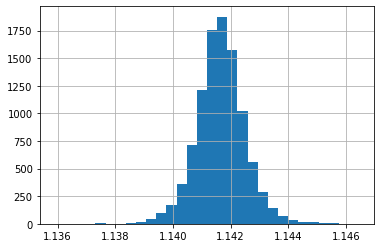


Current price: 1.1416,
Future reference price: 1.1417,
Future quantile price: 1.1395,
Relative VaR_99%: 0.19%
      


In [ ]:
# Сгенерируем возможные изменения процентных ставок на горизонте 1 день

N = 10_000

factors_gen = pd.DataFrame(
    {
    f'factor{i+1}':dist(*models[i]).rvs(N) for i in range(k)
}
)
diff_gen = factors_gen@coeff_rescaled[:k,:]
diff_gen.columns = terms
potential_rates = rates.loc[valuation_date, :].values + diff_gen

risk_date = np.datetime64('2020-04-07')
bond_CF = get_bond_CF(bond, risk_date)
reference_price = bond_pricing(bond_CF, get_curve(rates.loc[:valuation_date, :], valuation_date))['price']
scenarios = bond_pricing_vec(
        bond_CF,
        get_curve_vec(potential_rates, potential_rates.index)
    )
potential_prices = pd.Series([x['price'] for x in scenarios])

plt.hist(potential_prices, bins = 30)
plt.grid()
plt.show()

level = .99
quantile_price = potential_prices.quantile(1 - level, interpolation = 'higher')
print(
    '''
Current price: {:.4f},
Future reference price: {:.4f},
Future quantile price: {:.4f},
Relative VaR_{:.0%}: {:.2%}
      '''.format(curr_price,
                 reference_price,
                 quantile_price,
                 level,
                 (reference_price - quantile_price)/reference_price
                 ))


Теперь у нас есть изменений кривой процентных ставок, основанной на трех ортоганальных (некоррелированных) факторах

# О бэктесте моделей риска облигаций

Структура портфеля для бэктеста:

- реальные (устаревающие) облигации?
- фиксированный портфель - одинаковые потоки платежей?
- постоянная стоимостная структура?
- постоянная чувствительность портфеля?